# Leads recommender

### Understending the problem

**Objective**

The purpose of this product is to provide an automated service that recommends leads to a user given their current customer list (Portfolio).

**Context**

Some companies would like to know who are the other companies in a given market (population) that are most likely to become their next customers. That is, your solution must find in the market who are the most adherent leads given the characteristics of the customers present in the user's portfolio.

In addition, your solution must be user agnostic. Any user with a list of customers who want to explore this market can extract value from the service.

For the challenge, the following bases should be considered:

> Market: Base with information about the companies in the market to be  considered. 

> Portfolio 1: Company customer ids 1

> Portfolio 2: Company customer ids 2

> Portfolio 3: Company customer ids 3

Note: all companies (ids) in the portfolios are contained in the Market (population base).

Link to download the market, portfolio 1, portfolio 2 and portfolio 3 datasets: [bit.ly/leadsrecommender-data](http://bit.ly/leadsrecommender-data)

# General setup

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
import time
import pickle

## Datasets

In [3]:
#Reading main dataframe
raw_market = pd.read_csv('../data/estaticos_market.csv', index_col='id')

In [4]:
#Showing the main df
market = raw_market.copy().drop(columns = 'Unnamed: 0')
market.head()

,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
id,,,,,,,,,,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,False,...,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02edc5147bc2a2535b08,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3348900fe63216a439d2e5238c79ddd46ede454df7b9d8c24ac33eb21d4b21ef,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4b102c769f7611ab29f,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
#Reading portfolios
raw_portfolio1 = pd.read_csv('../portfolios/estaticos_portfolio1.csv', index_col='id').drop(columns = 'Unnamed: 0')
raw_portfolio2 = pd.read_csv('../portfolios/estaticos_portfolio2.csv', index_col='id').drop(columns = 'Unnamed: 0')
raw_portfolio3 = pd.read_csv('../portfolios/estaticos_portfolio3.csv', index_col='id').drop(columns = 'Unnamed: 0')

# Exploratory Data Analysis and Data Muning

NOTE: To a better understanding of the choices made here, see the [features dictionary](https://github.com/w-rfrsh/leads-recommender/blob/master/data/features_dictionary.pdf)

### Usefull functions
**Defining some functions to drop a selected column, plot the distribution of values of a column and encode a dataframe.**

In [6]:
def drop_col(df, col):
    try:
        df.drop(columns = col, inplace=True)
    except:
        print(f'The column {col} does not exist or has lready been removed.')

In [7]:
def plot_distribution(df, column, num_labels=None):
    # Generate a list with lists that contain a value and its respective incidence
    value_counts = []
    for k, v in df[column].value_counts().items():
        value_counts.append(list([k,v]))
    for count in value_counts:
        count[1]=count[1]/df.shape[0]
    
    # Set the maximum legend label length to 50 characters, adding '...' if you exceed this limit
    try:
        legend_labels = [[count[0], count[0][:50]+'...'][len(count[0])>50] for count in value_counts[:num_labels]]    
    except: # Avoid errors if the value is not a string
        legend_labels = [count[0] for count in value_counts[:num_labels]]
    
    # Plot the chart
    fig, axes = plt.subplots(figsize=(20, 2))
    pd.DataFrame([counts[1] for counts in value_counts]).T.plot(kind='barh', stacked=True, legend=False, ax=axes)
    sns.despine(left=True)
    
    plt.legend(legend_labels, bbox_to_anchor=(0.5,-0.2), loc='upper center', ncol=3)

In [8]:
def encode(df):
    # Separate categorical and numerical columns
    categorical_columns = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # One hot encode categorical columns
    df_processed = pd.get_dummies(data=df, columns=categorical_columns)

    # Scale numerical columns
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[numerical_columns])
    df_processed[numerical_columns] = scaled_data

    return df_processed

### Feature selection
**In this section, we will analyse the behavior of the features and select wich are usefull to the model.**

First of all, we must analyse the distribution of missing values of the main dataset.

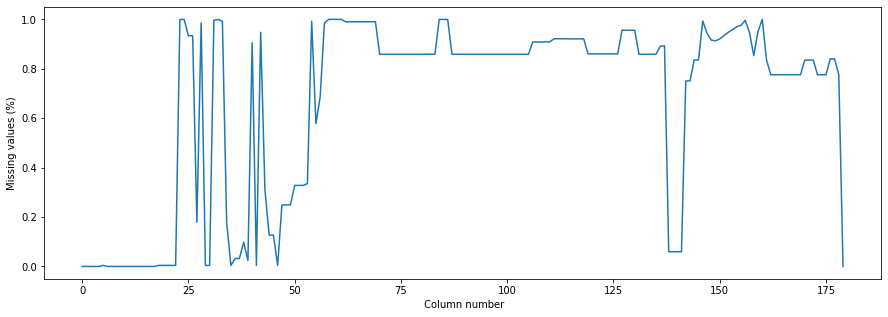

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=range(0, market.shape[1]), y=market.isnull().mean())
ax.set(xlabel=' Column number', ylabel='Missing values (%)')
plt.show()

As we can see, several columns have most of their values as missing. Therefore, let's remove them, taking the 67% threshold as the minimum of non-missing data in a given variable.

In [10]:
threshold = 0.70
market =  market.loc[:, market.notnull().mean() > threshold]

---
The recommendation we seek is independent of whether it is a parent company or not. Thus, the ```fl_matriz``` column  does not have relevance to our model, let's drop it.


In [11]:
drop_col(market, 'fl_matriz')

----
Now we are going to take a look at ```natureza_juridica_macro``` and ```de_natureza_juridica```.

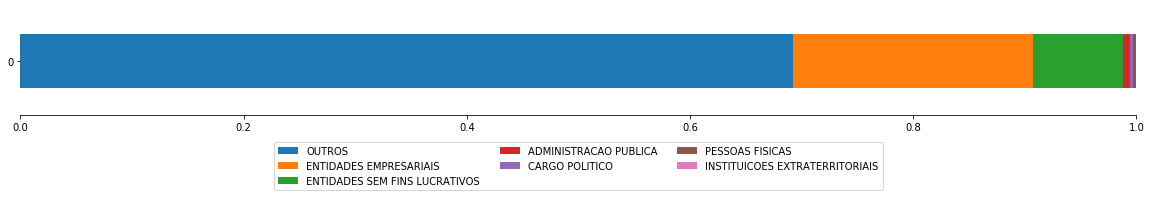

In [12]:
plot_distribution(market, 'natureza_juridica_macro')

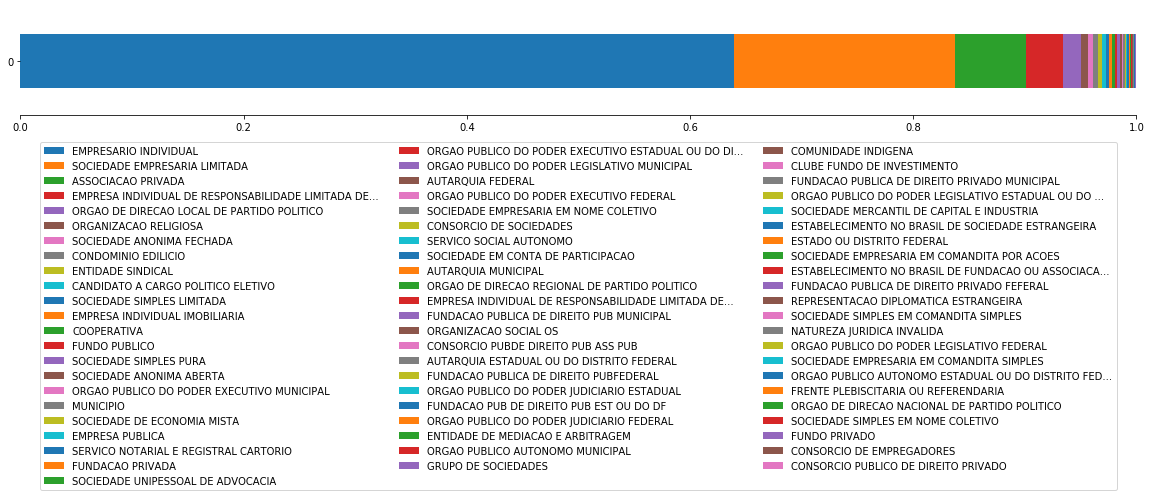

In [13]:
plot_distribution(market, 'de_natureza_juridica')

It is noticeable that ```de_natureza_juridica``` describe the same as ```natureza_juridica_macro```, but in more detail. That said, in order to become more general, we can drop the specificist column.

In [14]:
drop_col(market, 'de_natureza_juridica')

---
Let's inspect now ```setor```, ```nm_divisao```, ```nm_segmento``` and ```de_ramo```.

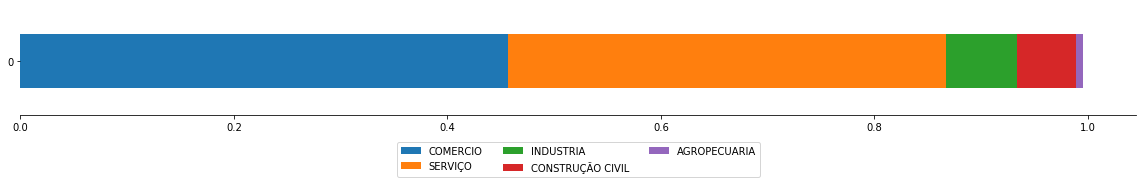

In [15]:
plot_distribution(market, 'setor')

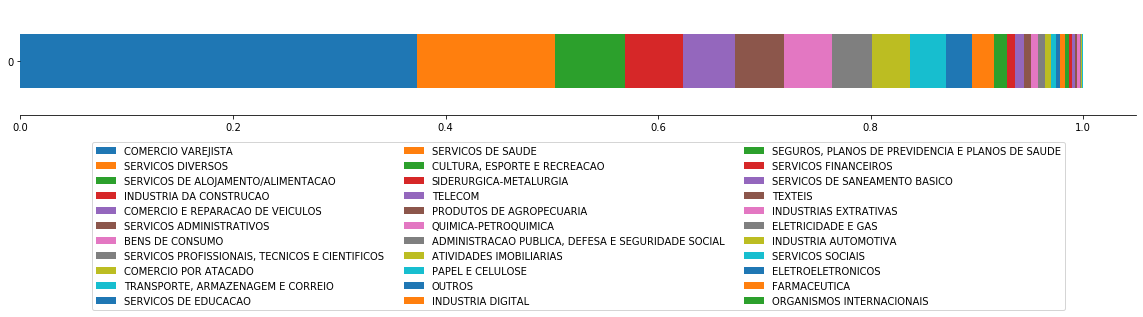

In [16]:
plot_distribution(market, 'de_ramo')

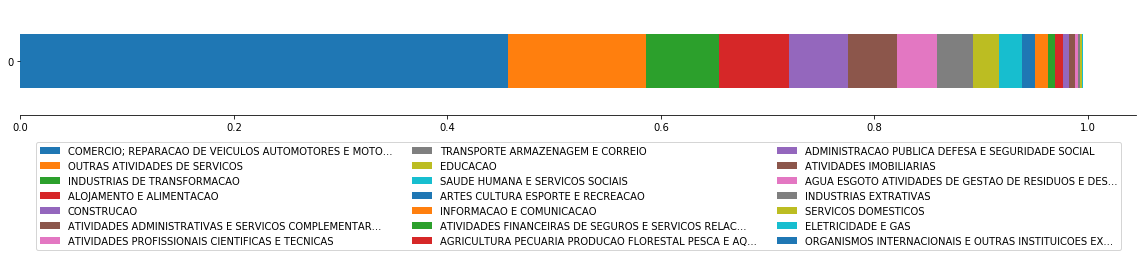

In [17]:
plot_distribution(market, 'nm_segmento')

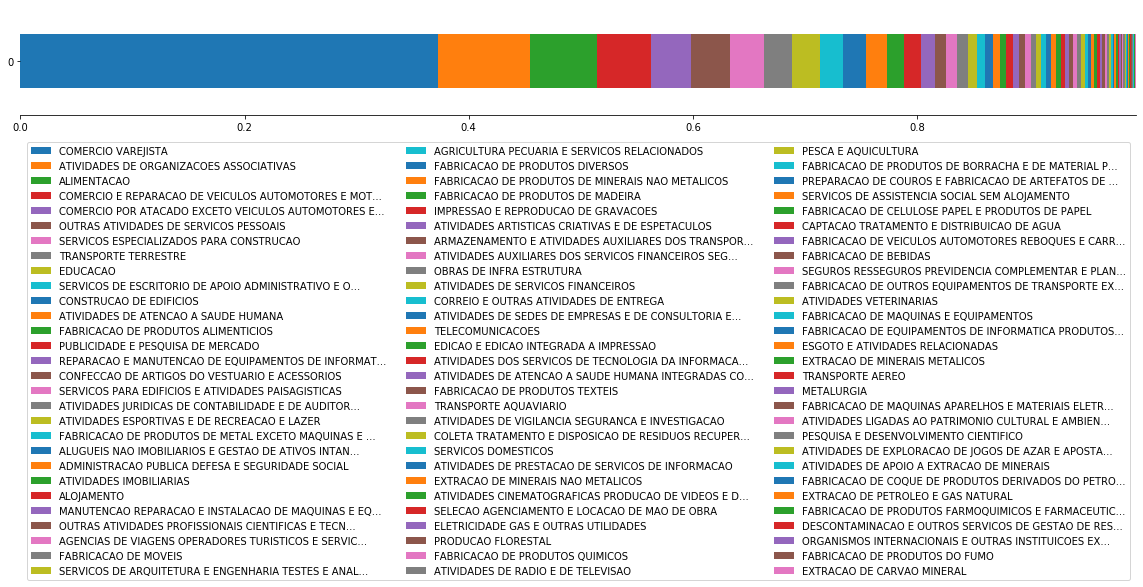

In [18]:
plot_distribution(market, 'nm_divisao')

As before, here we have some variables that differ in the degree of specificity. We will remain with a intermediate one, ```nm_segmento``` sounds a good choice.

In [19]:
drop_col(market, 'setor')
drop_col(market, 'de_ramo')
drop_col(market, 'nm_divisao')

---
The next ones to be analysed is ```idade_empresa_anos``` and ```idade_emp_cat```.

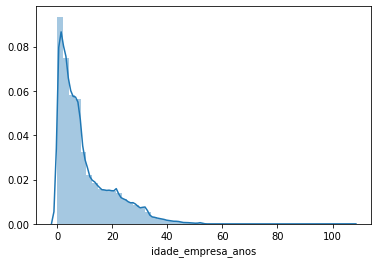

In [20]:
fig, axes = plt.subplots()
sns.distplot(market['idade_empresa_anos'])

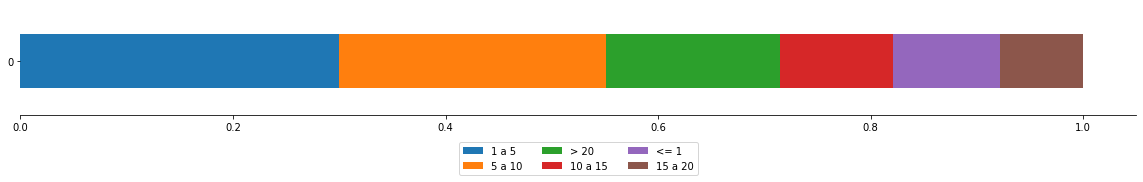

In [21]:
plot_distribution(market, 'idade_emp_cat')

To avoid a increase the dimensionality of our data, let's choose ```idade_empresas_anos``` to work with.

In [22]:
drop_col(market, 'idade_emp_cat')

---
The following variables tell us, primarily about the name of the companies and, in a second level, about the size of it. Although the second information may be relevant, there are other variables in the dataset that are better for this purpose.

In [23]:
drop_col(market, 'fl_me')
drop_col(market, 'fl_sa')
drop_col(market, 'fl_epp')
drop_col(market, 'fl_mei')
drop_col(market, 'fl_ltda')

----
To our purpose, information about a possible extraordinary situation is identified by the IRS is not relevant. Thus, we will drop ```dt_situacao``` and ```fl_st_especial```.

In [24]:
drop_col(market, 'dt_situacao')
drop_col(market, 'fl_st_especial')

The next one is about if the companies performs any activity that is taxable under ISS and, also, is not relevant. 

In [25]:
drop_col(market, 'fl_passivel_iss')


In addition, ```fl_email``` and ```fl__telefone``` are not relevant because they just tell us about if there is a email or phone number registred in IRS database.

In [26]:
drop_col(market, 'fl_email')
drop_col(market, 'fl_telefone')

---
Now, let's take a look at ```fl_spa```, ```fl_ant```, ```fl_veiculo```, ```vl_total_veiculos_leves_grupo``` and ```vl_total_veiculos_pesados_grupo```.

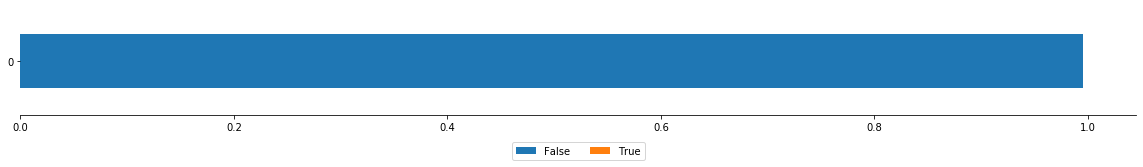

In [27]:
plot_distribution(market, 'fl_spa')

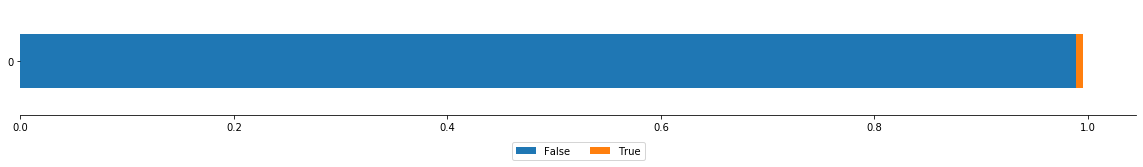

In [28]:
plot_distribution(market, 'fl_antt')

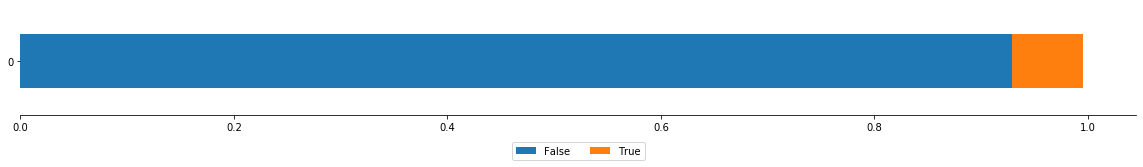

In [29]:
plot_distribution(market, 'fl_veiculo')

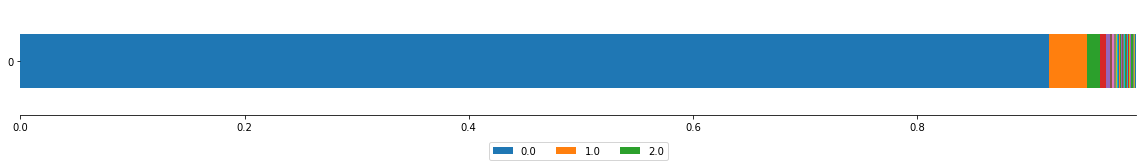

In [30]:
plot_distribution(market, 'vl_total_veiculos_leves_grupo', num_labels=3)

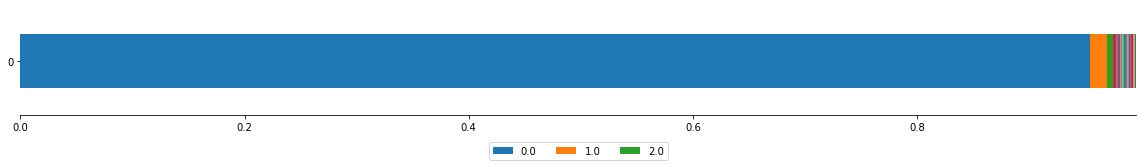

In [31]:
plot_distribution(market, 'vl_total_veiculos_pesados_grupo', num_labels=3)

We will drop all five variables because they have at least 90% of the distribution as a single value.

In [32]:
drop_col(market, 'fl_spa')
drop_col(market, 'fl_antt')
drop_col(market, 'fl_veiculo')
drop_col(market, 'vl_total_veiculos_leves_grupo')
drop_col(market, 'vl_total_veiculos_pesados_grupo')

----
The following variables deal with the company's financial health and the date of the last update of this item.For our purpose, they are disposable.


In [33]:
drop_col(market, 'de_saude_tributaria')
drop_col(market, 'de_saude_rescencia')
drop_col(market, 'nu_meses_rescencia')

---
Let's take a look at ```nm_meso_regiao``` ,```nm_micro_regiao``` and ```sg_uf```.

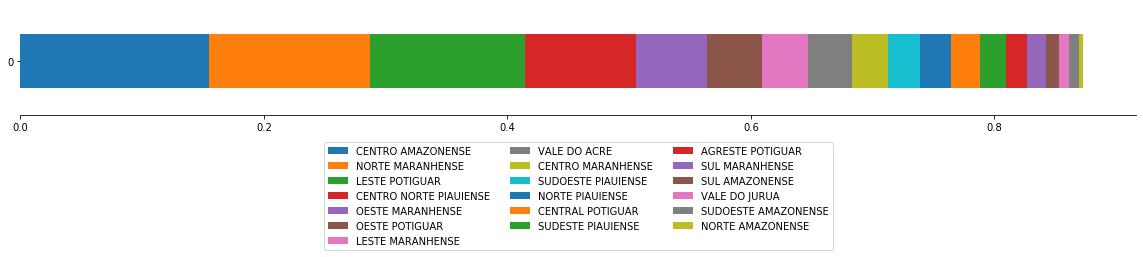

In [34]:
plot_distribution(market, 'nm_meso_regiao')

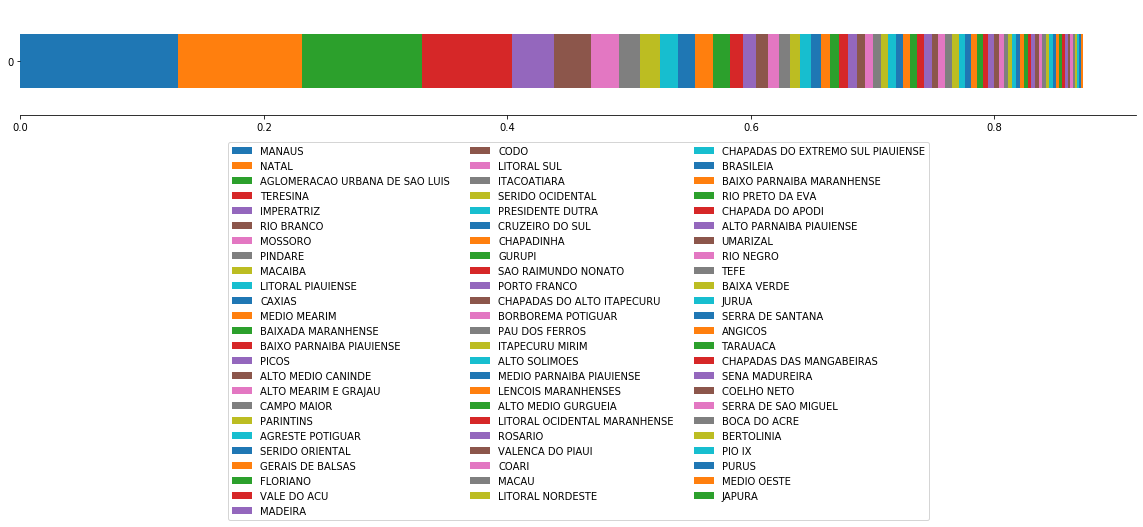

In [35]:
plot_distribution(market, 'nm_micro_regiao')

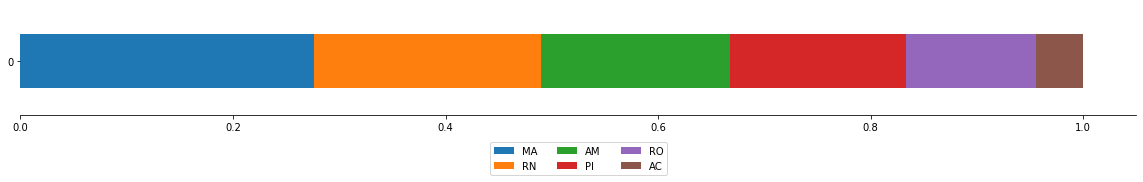

In [36]:
plot_distribution(market, 'sg_uf')

As has already happened, here we have the case of variables that deal strictly with the same issue (location), but with different degrees of specificity. Let's stay with the most generalist, which is the ```sg_uf```.

In [37]:
drop_col(market, 'nm_meso_regiao')
drop_col(market, 'nm_micro_regiao')

---
All of the variables below inform us about the company's partners. This kind of data is irrelevant, let's drop these columns.

In [38]:
drop_col(market, 'qt_socios')
drop_col(market, 'qt_socios_pf')
drop_col(market, 'qt_socios_pj')

---
Here we have another group of variables to be analyzed: ```vl_faturamento_estimado_grupo_aux``` and  ```de_faixa_faturamento_estimado_grupo```.

As we want to recommend leads, data about the group in which a company belongs is not important to us. Let's drop ```vl_faturamento_estimado_grupo_aux```,  ```de_faixa_faturamento_estimado_grupo``` and ```sg_uf_matriz```.

In [39]:
drop_col(market, 'vl_faturamento_estimado_grupo_aux')
drop_col(market, 'de_faixa_faturamento_estimado_grupo')
drop_col(market, 'sg_uf_matriz')

---
Now, let's see ```vl_faturamento_estimado_aux``` and ```de_faixa_faturamento_estimado```.

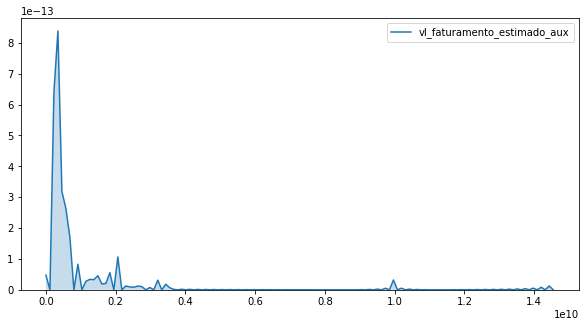

In [40]:
fig, axes = plt.subplots(figsize=(10, 5))
sns.kdeplot(market['vl_faturamento_estimado_aux'], shade=True)

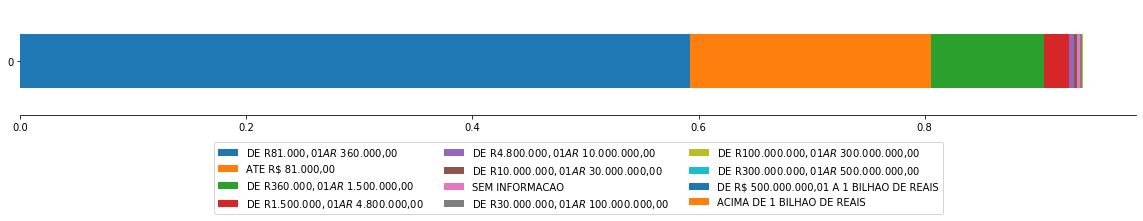

In [41]:
plot_distribution(market, 'de_faixa_faturamento_estimado')

The two variables previously plotted are the same thing, ```de_faixa_faturamento_estimado``` being a categorical version of ```vl_faturamento_estimado_aux```. In order not to increase the dimensionality, we will keep the numeric one.

In [42]:
drop_col(market, 'de_faixa_faturamento_estimado')

---
The ```qt_filiais``` column have a low variance, because approximately
90% of companies have 0 subsidiaries.

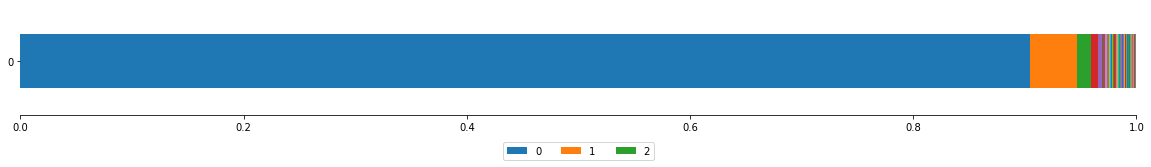

In [43]:
plot_distribution(market, 'qt_filiais', num_labels=3)

Thus, let's drop it.

In [44]:
drop_col(market, 'qt_filiais')

---
The following variables are about the company's tax regime and this information is irrelevant to the problem in question.

In [45]:
drop_col(market, 'fl_optante_simei')
drop_col(market, 'fl_optante_simples')
drop_col(market, 'fl_simples_irregular')

---
The probability of company being operating is irrelevant by now, so we can drop```de_nivel_atividade```.

In [46]:
drop_col(market, 'de_nivel_atividade')

--- 
**Overview of selected columns**



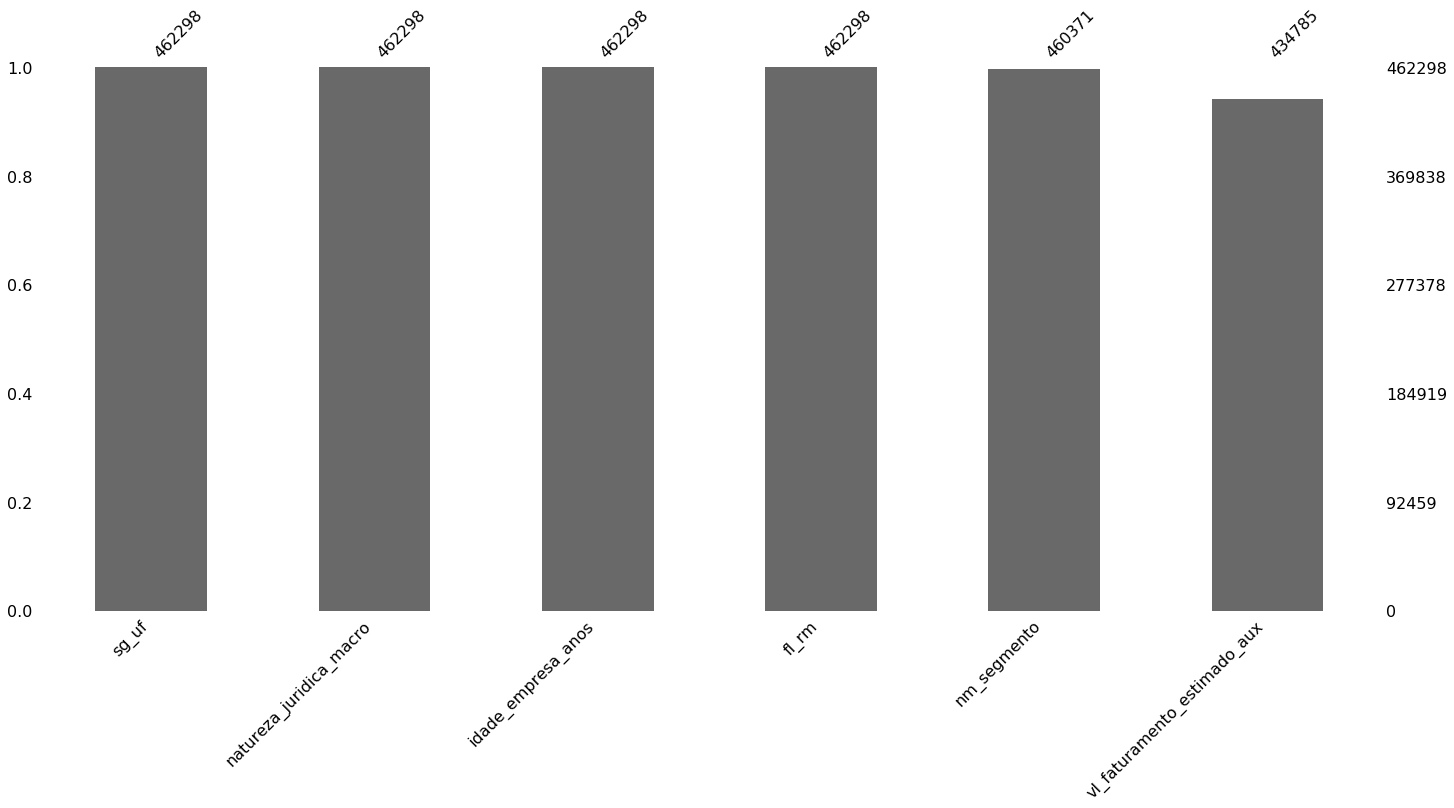

In [47]:
msno.bar(market)

We have little missing values, let's check if we can drop them without considerably impact.

In [48]:
market.dropna(how='any').shape[0]/market.shape[0]

0.9363224586738425

Our dataset is a very large dataset and these 7% of observations with a missing value will not be missed.

In [49]:
market = market.dropna(how='any')

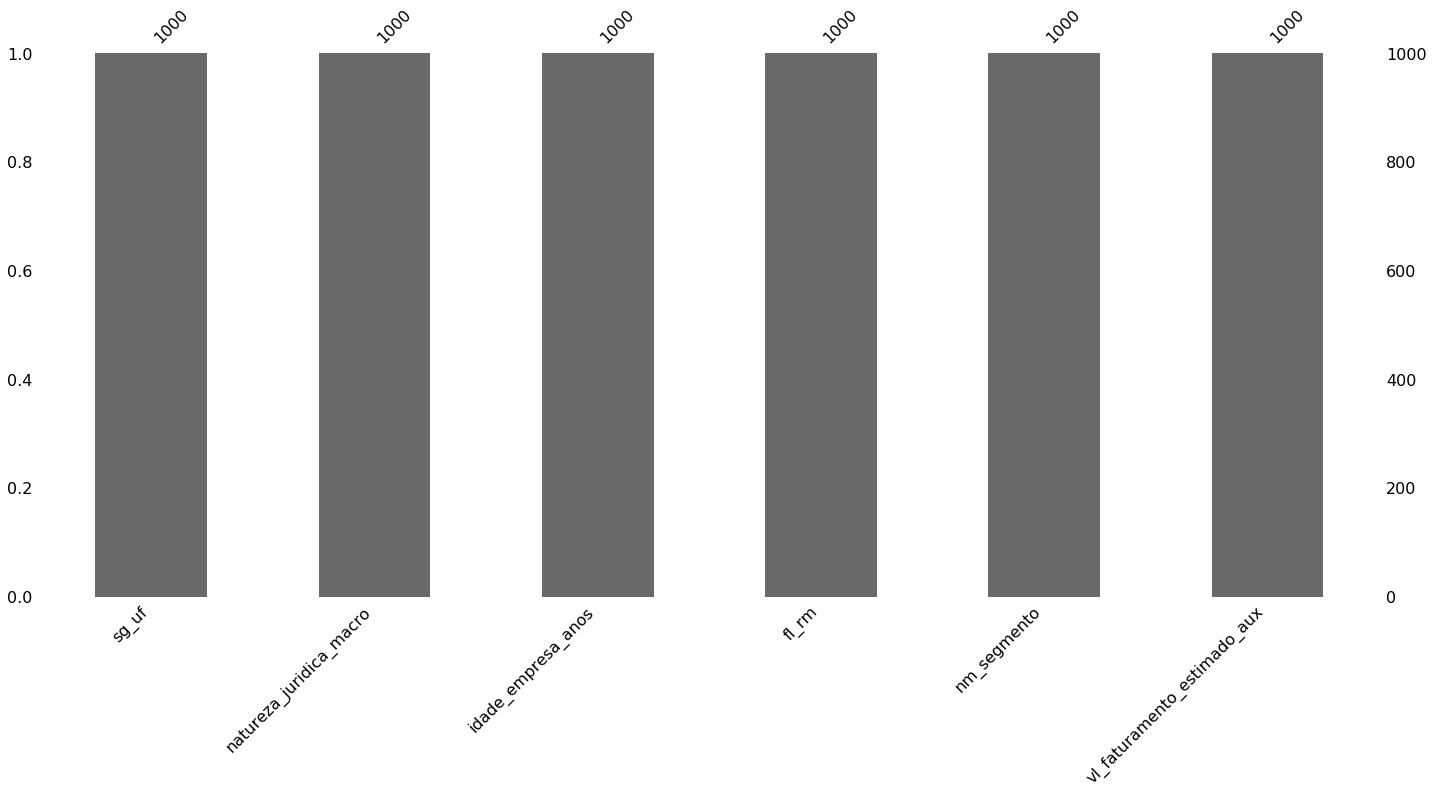

In [50]:
msno.bar(market.sample(1000))

### Enconding
**In this section, we will make the last adjustments in our data to finally use it in our models.**

Inicially, let's replace SIM and NAO by 1 an 0 in ```fl_rm``` column.

In [51]:
market = market.replace({'fl_rm': {'SIM': 1, 'NAO': 0}})

Now, let's use One Hot Encoding in our categorical variables and scale the numerical ones with the earlier defined function ```encode```.

In [52]:
processed_market = encode(market)

Based on their IDs, we were able to build a dataframe already processed for each portfolio.

In [53]:
processed_portfolio1 = processed_market.reindex(raw_portfolio1.index)
processed_portfolio2 = processed_market.reindex(raw_portfolio2.index)
processed_portfolio3 = processed_market.reindex(raw_portfolio3.index)

Visualizing the results:

In [54]:
processed_market.head()

,idade_empresa_anos,fl_rm,vl_faturamento_estimado_aux,sg_uf_AC,sg_uf_AM,sg_uf_MA,sg_uf_PI,sg_uf_RN,sg_uf_RO,natureza_juridica_macro_ADMINISTRACAO PUBLICA,...,nm_segmento_EDUCACAO,nm_segmento_ELETRICIDADE E GAS,nm_segmento_INDUSTRIAS DE TRANSFORMACAO,nm_segmento_INDUSTRIAS EXTRATIVAS,nm_segmento_INFORMACAO E COMUNICACAO,nm_segmento_ORGANISMOS INTERNACIONAIS E OUTRAS INSTITUICOES EXTRATERRITORIAIS,nm_segmento_OUTRAS ATIVIDADES DE SERVICOS,nm_segmento_SAUDE HUMANA E SERVICOS SOCIAIS,nm_segmento_SERVICOS DOMESTICOS,nm_segmento_TRANSPORTE ARMAZENAGEM E CORREIO
id,,,,,,,,,,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,0.135548,1.0,0.000215,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,0.013416,1.0,0.000014,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02edc5147bc2a2535b08,0.066332,1.0,0.000003,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3348900fe63216a439d2e5238c79ddd46ede454df7b9d8c24ac33eb21d4b21ef,0.060873,1.0,0.000014,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4b102c769f7611ab29f,0.029741,1.0,0.000014,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
processed_portfolio1.head()

,idade_empresa_anos,fl_rm,vl_faturamento_estimado_aux,sg_uf_AC,sg_uf_AM,sg_uf_MA,sg_uf_PI,sg_uf_RN,sg_uf_RO,natureza_juridica_macro_ADMINISTRACAO PUBLICA,...,nm_segmento_EDUCACAO,nm_segmento_ELETRICIDADE E GAS,nm_segmento_INDUSTRIAS DE TRANSFORMACAO,nm_segmento_INDUSTRIAS EXTRATIVAS,nm_segmento_INFORMACAO E COMUNICACAO,nm_segmento_ORGANISMOS INTERNACIONAIS E OUTRAS INSTITUICOES EXTRATERRITORIAIS,nm_segmento_OUTRAS ATIVIDADES DE SERVICOS,nm_segmento_SAUDE HUMANA E SERVICOS SOCIAIS,nm_segmento_SERVICOS DOMESTICOS,nm_segmento_TRANSPORTE ARMAZENAGEM E CORREIO
id,,,,,,,,,,,,,,,,,,,,,
dabe79bec87c88ae04e869bf6bd321ee5e1893cecf66255be9ea861a9e5841a9,0.005742,0.0,0.000014,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32e5f4e10932153a7ba869cb0386e7e02d49d2461046b866411556d2af150702,0.061568,0.0,0.000014,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a95d6f30bba445bd3d6b0c5b36f865b38ec01d1733609095d359649cfedf15d1,0.074958,1.0,0.000003,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6cb309685cea0b6d2988818792ec2e6fcb2bd02e0afa9e74532d5040fbc933b8,0.195751,0.0,0.000003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f72aa7fa6787b0a5a1c88885b6120850df8ee0f71adc251dfe8d321e9e6de7f5,0.175666,1.0,0.000208,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
processed_portfolio2.head()

,idade_empresa_anos,fl_rm,vl_faturamento_estimado_aux,sg_uf_AC,sg_uf_AM,sg_uf_MA,sg_uf_PI,sg_uf_RN,sg_uf_RO,natureza_juridica_macro_ADMINISTRACAO PUBLICA,...,nm_segmento_EDUCACAO,nm_segmento_ELETRICIDADE E GAS,nm_segmento_INDUSTRIAS DE TRANSFORMACAO,nm_segmento_INDUSTRIAS EXTRATIVAS,nm_segmento_INFORMACAO E COMUNICACAO,nm_segmento_ORGANISMOS INTERNACIONAIS E OUTRAS INSTITUICOES EXTRATERRITORIAIS,nm_segmento_OUTRAS ATIVIDADES DE SERVICOS,nm_segmento_SAUDE HUMANA E SERVICOS SOCIAIS,nm_segmento_SERVICOS DOMESTICOS,nm_segmento_TRANSPORTE ARMAZENAGEM E CORREIO
id,,,,,,,,,,,,,,,,,,,,,
09e95c1a84049001d086470a8f320a19b076f955a89122ff8360ac2e4d6eca5d,0.105343,0.0,0.022513,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
dc9d155f5bcd3172031e2ec9431786e8871ff4b0ff4728bb62194ca0842cce3e,0.411227,1.0,0.012154,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
16843c9ffb920170477118933798510d8d5f00f5c56c1221773356355bded321,0.153702,0.0,0.001912,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ff045934d90aab184dd15e66daf3b3c97193bda5449298784b664681610609a0,0.372525,0.0,0.015228,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a0ce528caab2c62497a548d0ebd9e935143ef81ed7dbf074dcd7e0c7dd50ae11,0.190164,0.0,0.001934,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
processed_portfolio3.head()

,idade_empresa_anos,fl_rm,vl_faturamento_estimado_aux,sg_uf_AC,sg_uf_AM,sg_uf_MA,sg_uf_PI,sg_uf_RN,sg_uf_RO,natureza_juridica_macro_ADMINISTRACAO PUBLICA,...,nm_segmento_EDUCACAO,nm_segmento_ELETRICIDADE E GAS,nm_segmento_INDUSTRIAS DE TRANSFORMACAO,nm_segmento_INDUSTRIAS EXTRATIVAS,nm_segmento_INFORMACAO E COMUNICACAO,nm_segmento_ORGANISMOS INTERNACIONAIS E OUTRAS INSTITUICOES EXTRATERRITORIAIS,nm_segmento_OUTRAS ATIVIDADES DE SERVICOS,nm_segmento_SAUDE HUMANA E SERVICOS SOCIAIS,nm_segmento_SERVICOS DOMESTICOS,nm_segmento_TRANSPORTE ARMAZENAGEM E CORREIO
id,,,,,,,,,,,,,,,,,,,,,
bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe24b56a3e11f7d6a0bce,0.204686,0.0,0.009714,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16843c9ffb920170477118933798510d8d5f00f5c56c1221773356355bded321,0.153702,0.0,0.001912,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1b8d092daff12bed8b3c2ab93bf5df2921865a68aca185f51e31e7105abb0c48,0.379194,1.0,0.006375,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3aafa3a1f12f483740a52956af100223333d0e3c79bf2ce341896dd554e72293,0.411845,1.0,0.001679,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c60431fbca90067f105570e1e8a684bcd7048205bbf6c40d71c3d558626f2344,0.411948,0.0,0.002653,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Machine Learning Algorithms

Now, taking an overview of the problem, we have the following situation:
We need to create a system that recommends leads **based on certain characteristics** of a set of companies that are clients of a company.
So we are going to use the content based system approach here.

According to Charu C. Aggarwal in the book _Recommender Systems: The Textbook_, "in content-based recommender systems, the descriptive attributes of items are used to make recommendations. The term “content” refers to these descriptions. In content-based methods, the ratings and buying behavior of users are combined with the content information available in the items."


## Nearest Neighbors 
One of the most recurrent paths for this type of problem is the use of the **Nearest Neighbor** method. Thus, we will implement it below.

### Fitting the model
First, let's fit our model using ```processed_market ```dataframe. For each companie of our portfolio, let's pick 10 neighbors for it. 

In [98]:
model_knn = NearestNeighbors(algorithm='ball_tree', n_neighbors=10, n_jobs=-1)

start = time.time()
model_knn.fit(processed_market)
end = time.time()

In [99]:
print(f'Time spent: {round(end-start)} seconds.')

Time spent: 452 seconds.


### Recommender
Building a recommender function.

In [100]:
def recommender(portfolio):
    # Raw portfolio
    raw_portfolio = market.reindex(portfolio.index)
    
    # Finds the neighbors for each company of portfolio
    dist, indices = model_knn.kneighbors(portfolio.dropna())

    # Build a dataframe with dist and indices
    leads = pd.DataFrame(list(zip(processed_market.index[indices.flatten()], dist.flatten())), columns=['id', 'distance'])

    # Sort values by distance
    leads = leads.sort_values('distance').set_index('id')

    # Remove duplicates and companies already included in portfolio
    leads = leads.loc[~leads.index.duplicated(keep='first')]
    leads = leads.drop([x for x in leads.index if x in portfolio.index])
        
    # Build a raw leads dataframe
    raw_leads = raw_market.reindex(leads.index)
    # Remove recommendations if nm_segmento do not included at original portfolio
    raw_leads = raw_leads[raw_leads['nm_segmento'].isin(raw_portfolio['nm_segmento'].unique())]
    # Build a processed leads dataframe
    processed_leads = processed_market.reindex(raw_leads.index)

    return raw_leads, processed_leads

---
Generating and vizualising pre processed and processed leads for portfolio 1.

In [101]:
raw_leads1, processed_leads1 = recommender(processed_portfolio1)

In [102]:
processed_leads1.head()

,idade_empresa_anos,fl_rm,vl_faturamento_estimado_aux,sg_uf_AC,sg_uf_AM,sg_uf_MA,sg_uf_PI,sg_uf_RN,sg_uf_RO,natureza_juridica_macro_ADMINISTRACAO PUBLICA,...,nm_segmento_EDUCACAO,nm_segmento_ELETRICIDADE E GAS,nm_segmento_INDUSTRIAS DE TRANSFORMACAO,nm_segmento_INDUSTRIAS EXTRATIVAS,nm_segmento_INFORMACAO E COMUNICACAO,nm_segmento_ORGANISMOS INTERNACIONAIS E OUTRAS INSTITUICOES EXTRATERRITORIAIS,nm_segmento_OUTRAS ATIVIDADES DE SERVICOS,nm_segmento_SAUDE HUMANA E SERVICOS SOCIAIS,nm_segmento_SERVICOS DOMESTICOS,nm_segmento_TRANSPORTE ARMAZENAGEM E CORREIO
id,,,,,,,,,,,,,,,,,,,,,
e0edf8b82dfcc699ed3e6693511283b00e81a731aa8359cbf905037f2cab989d,0.130604,0.0,0.000014,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f93d36ba7435823ae08ac30b7e570be68ab23f9f3b8b8bb9a96b609846f545da,0.059560,0.0,0.000014,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
e372509fdf57e76b09fe52ecd5acf7c1523eb0dd2fa5a49493f93b5e244c81cd,0.059560,0.0,0.000014,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3ec5bd2cf557336db11161340d5035b1303ed716ae8818b2be44da731927b64a,0.014652,1.0,0.000014,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dad3628aace89a61c6325dec386d823f3d4c4967c88de43facf903d21defc99e,0.106785,0.0,0.000014,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
raw_leads1.head()

,Unnamed: 0,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
id,,,,,,,,,,,,,,,,,,,,,
e0edf8b82dfcc699ed3e6693511283b00e81a731aa8359cbf905037f2cab989d,29180,True,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,13.931507,10 a 15,False,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0
f93d36ba7435823ae08ac30b7e570be68ab23f9f3b8b8bb9a96b609846f545da,265964,True,EMPRESA INDIVIDUAL DE RESPONSABILIDADE LIMITAD...,MA,OUTROS,BENS DE CONSUMO,INDUSTRIA,6.372603,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
e372509fdf57e76b09fe52ecd5acf7c1523eb0dd2fa5a49493f93b5e244c81cd,284601,True,EMPRESARIO INDIVIDUAL,MA,OUTROS,PAPEL E CELULOSE,INDUSTRIA,6.372603,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3ec5bd2cf557336db11161340d5035b1303ed716ae8818b2be44da731927b64a,24935,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,COMERCIO VAREJISTA,COMERCIO,1.594521,1 a 5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
dad3628aace89a61c6325dec386d823f3d4c4967c88de43facf903d21defc99e,372121,True,EMPRESARIO INDIVIDUAL,MA,OUTROS,COMERCIO VAREJISTA,COMERCIO,11.397260,10 a 15,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


---
Generating and vizualising pre processed and processed leads for portfolio 2.

In [104]:
raw_leads2, processed_leads2 = recommender(processed_portfolio2)

In [105]:
processed_leads2.head()

,idade_empresa_anos,fl_rm,vl_faturamento_estimado_aux,sg_uf_AC,sg_uf_AM,sg_uf_MA,sg_uf_PI,sg_uf_RN,sg_uf_RO,natureza_juridica_macro_ADMINISTRACAO PUBLICA,...,nm_segmento_EDUCACAO,nm_segmento_ELETRICIDADE E GAS,nm_segmento_INDUSTRIAS DE TRANSFORMACAO,nm_segmento_INDUSTRIAS EXTRATIVAS,nm_segmento_INFORMACAO E COMUNICACAO,nm_segmento_ORGANISMOS INTERNACIONAIS E OUTRAS INSTITUICOES EXTRATERRITORIAIS,nm_segmento_OUTRAS ATIVIDADES DE SERVICOS,nm_segmento_SAUDE HUMANA E SERVICOS SOCIAIS,nm_segmento_SERVICOS DOMESTICOS,nm_segmento_TRANSPORTE ARMAZENAGEM E CORREIO
id,,,,,,,,,,,,,,,,,,,,,
73773341b32011b71ac6a3cfc8f4e8836782c372f42effd0996860029d0830fa,0.204892,0.0,0.002529,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
df95b7f3ad63d35f1be8c9ef2c2aa74e40f230317eed5efa816563340a7ee53f,0.204712,0.0,0.001973,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66c7b309e10d8cac6c415af982ee7b8140a8724a7846b2deb7390f7b9c0ba8d5,0.204892,0.0,0.002043,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5eec7b8b514bc9d83e4fd55c160c3c814ed6d81e3fbb686f3a83eb67921033bc,0.205433,0.0,0.002805,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a6cd365607bd57ebe8605ec9aa029a92ddbc478a92c76ef225e83ee32a6166d6,0.204892,0.0,0.001827,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
raw_leads2.head()

,Unnamed: 0,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
id,,,,,,,,,,,,,,,,,,,,,
73773341b32011b71ac6a3cfc8f4e8836782c372f42effd0996860029d0830fa,359040,True,MUNICIPIO,PI,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,21.835616,> 20,False,...,165.595299,265.633333,34.033333,234.0,234.0,234.0,0.0,0.000000,0.0,0
df95b7f3ad63d35f1be8c9ef2c2aa74e40f230317eed5efa816563340a7ee53f,179265,True,MUNICIPIO,MA,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,21.816438,> 20,False,...,167.501675,367.133333,34.366667,199.0,199.0,199.0,0.0,0.000000,0.0,1
66c7b309e10d8cac6c415af982ee7b8140a8724a7846b2deb7390f7b9c0ba8d5,409910,True,MUNICIPIO,PI,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,21.835616,> 20,False,...,151.943172,260.933333,58.700000,227.0,227.0,227.0,0.0,0.000000,0.0,0
5eec7b8b514bc9d83e4fd55c160c3c814ed6d81e3fbb686f3a83eb67921033bc,355599,True,MUNICIPIO,MA,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,21.893151,> 20,False,...,142.077964,265.633333,24.200000,298.0,298.0,297.0,0.0,0.336700,0.0,2
a6cd365607bd57ebe8605ec9aa029a92ddbc478a92c76ef225e83ee32a6166d6,250865,True,MUNICIPIO,PI,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,21.835616,> 20,False,...,132.644505,316.366667,23.933333,182.0,182.0,181.0,0.0,0.552486,0.0,0


In [107]:
raw_leads1.nm_segmento.nunique()

2

---
Generating and vizualising pre processed and processed leads for portfolio 3.

In [108]:
raw_leads3, processed_leads3 = recommender(processed_portfolio3)

In [109]:
processed_leads3.head()

,idade_empresa_anos,fl_rm,vl_faturamento_estimado_aux,sg_uf_AC,sg_uf_AM,sg_uf_MA,sg_uf_PI,sg_uf_RN,sg_uf_RO,natureza_juridica_macro_ADMINISTRACAO PUBLICA,...,nm_segmento_EDUCACAO,nm_segmento_ELETRICIDADE E GAS,nm_segmento_INDUSTRIAS DE TRANSFORMACAO,nm_segmento_INDUSTRIAS EXTRATIVAS,nm_segmento_INFORMACAO E COMUNICACAO,nm_segmento_ORGANISMOS INTERNACIONAIS E OUTRAS INSTITUICOES EXTRATERRITORIAIS,nm_segmento_OUTRAS ATIVIDADES DE SERVICOS,nm_segmento_SAUDE HUMANA E SERVICOS SOCIAIS,nm_segmento_SERVICOS DOMESTICOS,nm_segmento_TRANSPORTE ARMAZENAGEM E CORREIO
id,,,,,,,,,,,,,,,,,,,,,
a333b90fd76570d46d00beb7d6cdffa913703f5bd02b76e41d428b5b704f30e7,0.204892,0.0,0.003417,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ca7d4d28883a04fa6ffda83f022de343847cb45bc9879f4998d0b5a93ff01435,0.204892,0.0,0.002082,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eee8be8a00d25a9647d1ceca1a6a596475d9b32395826e7ec9ed6026ead01402,0.204892,0.0,0.001863,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bbe6d9a4a88f3705e83523b48089777198c3e2c14d92f520fae7d0e323a0a5da,0.204892,0.0,0.003396,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66c7b309e10d8cac6c415af982ee7b8140a8724a7846b2deb7390f7b9c0ba8d5,0.204892,0.0,0.002043,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
raw_leads3.head()

,Unnamed: 0,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
id,,,,,,,,,,,,,,,,,,,,,
a333b90fd76570d46d00beb7d6cdffa913703f5bd02b76e41d428b5b704f30e7,238287,True,MUNICIPIO,PI,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,21.835616,> 20,False,...,136.627763,539.200000,27.266667,365.0,365.0,367.0,0.0,-0.544959,0.0,0
ca7d4d28883a04fa6ffda83f022de343847cb45bc9879f4998d0b5a93ff01435,67692,True,MUNICIPIO,PI,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,21.835616,> 20,False,...,119.898287,423.966667,28.300000,214.0,214.0,214.0,0.0,0.000000,0.0,0
eee8be8a00d25a9647d1ceca1a6a596475d9b32395826e7ec9ed6026ead01402,60713,True,MUNICIPIO,PI,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,21.835616,> 20,False,...,146.307591,265.633333,31.000000,202.0,202.0,217.0,0.0,-6.912442,0.0,1
bbe6d9a4a88f3705e83523b48089777198c3e2c14d92f520fae7d0e323a0a5da,41653,True,MUNICIPIO,PI,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,21.835616,> 20,False,...,148.401761,441.800000,25.100000,284.0,284.0,375.0,0.0,-24.266667,0.0,0
66c7b309e10d8cac6c415af982ee7b8140a8724a7846b2deb7390f7b9c0ba8d5,409910,True,MUNICIPIO,PI,OUTROS,"ADMINISTRACAO PUBLICA, DEFESA E SEGURIDADE SOCIAL",SERVIÇO,21.835616,> 20,False,...,151.943172,260.933333,58.700000,227.0,227.0,227.0,0.0,0.000000,0.0,0


### Evaluating
Let's define a evaluate function, here we will use MSE and MAE and check how many recommendations have 90% of similarity with at least one of the portfolio companies.

In [111]:
def evaluate_knn(processed_portfolio, processed_leads):
    # Create an array with average user data of portfolio and leads
    portfolio_average = np.array(processed_portfolio.apply(np.mean, axis=0))
    leads_average = np.array(processed_leads.apply(np.mean, axis=0))

    # Calcualtes Mean Squared Error and Mean Absolut Error
    MSE = mean_squared_error(portfolio_average, leads_average)
    MAE = mean_absolute_error(portfolio_average, leads_average)
    
    # Count how many recommended leads have 95% or more of similarity with  at least one company of portfolio
    high_sim = 0
    for lead in processed_leads.dropna().values:
        similarities = 1 - cdist([lead], processed_portfolio.dropna().values, metric='cosine')
        if similarities[similarities>0.95].shape[0] > 0:
            high_sim += 1
    high_sim_rate = high_sim/processed_leads.dropna().shape[0]
    
    return MSE, MAE, high_sim_rate

####  Evaluate leads for portfolio 1.

In [113]:
MSE, MAE, high_sim_rate = evaluate_knn(processed_portfolio1, processed_leads1)
print(f'Mean Squared Error: {MSE}')
print(f'Mean Absolute Error: {MAE} \n')
print(f'{round(high_sim_rate*100, 1)}% of recommendations with 95% or more of similiraty with at least one company of portfolio.')

Mean Squared Error: 1.0308032813875956e-06
Mean Absolute Error: 0.0004851218206114498 

100.0% of recommendations with 95% or more of similiraty with at least one company of portfolio.


####  Evaluate leads for portfolio 2.

In [116]:
MSE, MAE, high_sim_rate = evaluate_knn(processed_portfolio2, processed_leads2)
print(f'Mean Squared Error: {MSE}')
print(f'Mean Absolute Error: {MAE} \n')
print(f'{round(high_sim_rate*100, 1)}% of recommendations with 95% or more of similiraty with at least one company of portfolio.')

Mean Squared Error: 0.0017194443210211798
Mean Absolute Error: 0.020659520213450216 

99.8% of recommendations with 95% or more of similiraty with at least one company of portfolio.


####  Evaluate leads for portfolio 3.

In [117]:
MSE, MAE, high_sim_rate = evaluate_knn(processed_portfolio3, processed_leads3)
print(f'Mean Squared Error: {MSE}')
print(f'Mean Absolute Error: {MAE} \n')
print(f'{round(high_sim_rate*100, 1)}% of recommendations with 95% or more of similiraty with at least one company of portfolio.')

Mean Squared Error: 0.0041772254216576165
Mean Absolute Error: 0.033487163992956995 

99.2% of recommendations with 95% or more of similiraty with at least one company of portfolio.


In addition to the metrics used in this notebook, it is interesting to have a practical evaluation of the model for further improvement. This can be done by comparing the success rate in prospecting by customers with and without the use of the model.

### Saving

Saving KNN model.

In [118]:
with open('../model/leads-recommender-model.pkl', 'wb') as file:
    pickle.dump(model_knn, file)

Saving processed_market dataframe.

In [76]:
processed_market.to_csv('../data/processed_market.csv', index=True)